In [21]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


# Load COCO Dataset

In [22]:
dataDir='/home/yangqi/dataspace/COCO/'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)


loading annotations into memory...
Done (t=1.07s)
creating index...
index created!


In [23]:
def getClassName(classID, cats):
    """Get the class name according to classID

    Args:
        classID 
        cats 

    Returns:
        Class name
    """
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
print('The class name is:', getClassName(77, cats))

The class name is: cell phone


# Ground Truth

Number of images containing all the classes: 11


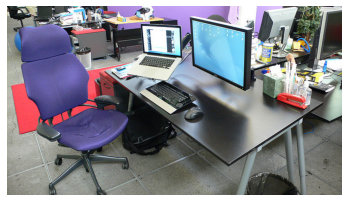

In [24]:
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['laptop', 'tv', 'cell phone']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/images/{}/{}'.format(dataDir,dataType,img['file_name']))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

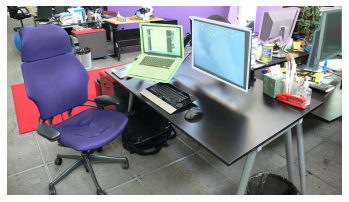

In [25]:
# Load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

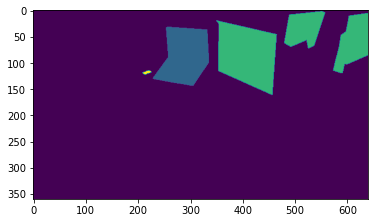

In [26]:
#### GENERATE A SEGMENTATION MASK ####
filterClasses = ['laptop', 'tv', 'cell phone']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

# Predict

In [27]:
from model.refinenet import rf101
from PIL import Image
import torch
import numpy as np

In [28]:
import os
num_classes = 21

os.environ["CUDA_VISIBLE_DEVICES"] = str(4)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = rf101(num_classes=num_classes, pretrained=True)
model = model.eval()
model = model.cuda()
model.load_state_dict(torch.load('checkpoints/refinenet101_voc.pth'))  

Using cuda device


<All keys matched successfully>

torch.Size([3, 512, 512])
[ 5.9621797  5.9621797  6.2302504  6.7663918  7.3025327  7.8386736
  8.099416   8.084759   8.0701     8.055443   8.028076   7.9880004
  7.947924   7.9078484  7.8762054  7.8529944  7.8297844  7.806574
  7.799325   7.8080387  7.8167515  7.825465   7.839022   7.8574233
  7.875825   7.8942266  7.912669   7.9311547  7.9496393  7.9681244
  8.003697   8.056357   8.109018   8.161678   8.23461    8.327812
  8.421014   8.514215   8.574003   8.600375   8.626748   8.65312
  8.629692   8.556464   8.483236   8.410008   8.351742   8.308435
  8.26513    8.221824   8.230462   8.291045   8.351627   8.41221
  8.471549   8.529645   8.58774    8.645837   8.676762   8.680516
  8.684272   8.688026   8.674048   8.642338   8.610626   8.578916
  8.549934   8.523683   8.497433   8.471181   8.461394   8.468071
  8.474748   8.481425   8.510841   8.562994   8.615149   8.667301
  8.716185   8.761797   8.807409   8.853021   8.8738785  8.86998
  8.866081   8.862182   8.837324   8.791505   8.7

(-0.5, 511.5, 511.5, -0.5)

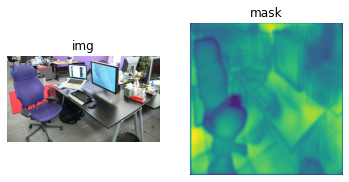

: 

In [30]:

%matplotlib inline
import cv2
import yaml
import matplotlib.pyplot as plt
import torch.nn as nn
cfg_path = open("configs/coco.yaml")
cfg = yaml.full_load(cfg_path)

image_file = os.path.join(dataDir , 'images/', dataType ,img['file_name'] )
 

original_image = Image.open(image_file).convert("RGB")
img = np.array(original_image)
orig_size = img.shape[:2][::-1]

from data.utils import custom_transforms as tr
from torchvision import transforms


transform=transforms.Compose([
        #transforms.ToPILImage(),  
        transforms.ToTensor(), #将图片转换为Tensor,归一化至[0,1]
        transforms.Resize((cfg['CROP_SIZE'],cfg['CROP_SIZE']))
        #transforms.Normalize(mean=cfg['DATASET']['MEAN'],std=cfg['DATASET']['STD']),
])

image = transform(img)
image = image.unsqueeze(0).cuda()
print(image.size()[1:])
prediction = model(image)

prediction = nn.functional.interpolate(
            prediction, size=image.size()[2:], mode="bilinear", align_corners=False)

prediction = prediction.cpu().detach().numpy()
mask = np.squeeze(prediction,0)
mask = np.max(mask, axis=0)
print(mask[10])


        
print(mask)
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title('img')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title('mask')
plt.axis('off')


